# 必要なもののインポート
今回は発言内容からどの会議で発言されたものか予測することを考える。

In [1]:
import pandas as pd
import numpy as np
import MeCab
import mojimoji
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn import svm
import matplotlib.pyplot as plt

%matplotlib inline

# データセットの読み込み

In [2]:
df_input = pd.read_csv('../data/kokkai.csv', header=0)
display(df_input.head())
print(len(df_input))

,date,house,meeting,speech_order,text
0,2019-12-03,参議院,経済産業委員会,0,令和元年十二月三日（火曜日）\r\n 午前十時開会\r\n ───────────...
1,2019-12-03,参議院,経済産業委員会,1,○委員長（礒崎哲史君） ただいまから経済産業委員会を開会いたします。\r\n 委員の異動につ...
2,2019-12-03,参議院,経済産業委員会,2,○委員長（礒崎哲史君） 政府参考人の出席要求に関する件についてお諮りいたします。\r\n 外...
3,2019-12-03,参議院,経済産業委員会,3,○委員長（礒崎哲史君） 御異議ないと認め、さよう決定いたします。\r\n ──────...
4,2019-12-03,参議院,経済産業委員会,4,○委員長（礒崎哲史君） 外国為替及び外国貿易法第十条第二項の規定に基づき、北朝鮮を仕向地とす...


14450


# 形態素解析の関数

In [3]:
def text_to_words(text, stop_word_pass='../stopwords/Japanese.txt'):
    # stopword listをつくる
    stopword_list = []
    with open(stop_word_pass, 'r') as f:
        stopword_list = f.readlines()
        
    stopword_list = [x.strip() for x in stopword_list if x.strip()] 
    #形態素解析を始める
    m = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')
    m.parse('')
    #text = normalize_text(text)
    text = mojimoji.zen_to_han(text, kana=False)
    m_text = m.parse(text)
    basic_words = []
    #mecabの出力結果を単語ごとにリスト化
    m_text = m_text.split('\n')
    for row in m_text:
        #Tab区切りで形態素、その品詞等の内容と分かれているので単語部のみ取得
        word = row.split("\t")[0]
        #最終行はEOS
        if word == 'EOS':
            break
        else:
            pos = row.split('\t')[1]
            slice_ = pos.split(',')
            #品詞を取得する
            parts = slice_[0]
            if parts == '記号':
                continue

            #活用語の場合は活用指定ない原型を取得する。
            elif slice_[0] in ('形容詞', '動詞') and slice_[-3] not in stopword_list:
                    basic_words.append(slice_[-3])

            #活用しない語についてはそのままの語を取得する
            elif slice_[0] =='名詞' and word not in stopword_list:
                basic_words.append(word)

    basic_words = ' '.join(basic_words)
    return basic_words

# 学習データの整形
本会議を0、経済産業員会を1とコード化する。また、発言内容を上記関数で分かち書きする。

In [4]:
meeting_index = {'本会議':0, '経済産業委員会':1}
df_input['meeting_index'] = [0 if x not in meeting_index or meeting_index[x] == 0 else 1 \
                             for x in df_input['meeting'].values.tolist()]
df_input['date'] = pd.to_datetime(df_input['date'])
df_input['text_ana'] = df_input['text'].map(text_to_words)

In [5]:
print('Dataset size:{}'.format(len(df_input)))
df_input.head()

Dataset size:14450


,date,house,meeting,speech_order,text,meeting_index,text_ana
0,2019-12-03,参議院,経済産業委員会,0,令和元年十二月三日（火曜日）\r\n 午前十時開会\r\n ───────────...,1,令和元年 十二月三日 火曜日 午前 十時 開会 委員 異動 十一月二十八日 辞任 補欠 選任...
1,2019-12-03,参議院,経済産業委員会,1,○委員長（礒崎哲史君） ただいまから経済産業委員会を開会いたします。\r\n 委員の異動につ...,1,委員長 礒崎哲史 君 経済産業委員会 開会 いたす 委員 異動 報告 いたす 昨日 三木亨 ...
2,2019-12-03,参議院,経済産業委員会,2,○委員長（礒崎哲史君） 政府参考人の出席要求に関する件についてお諮りいたします。\r\n 外...,1,委員長 礒崎哲史 君 政府参考人 出席 要求 件 諮る いたす 外国為替及び外国貿易法 第十...
3,2019-12-03,参議院,経済産業委員会,3,○委員長（礒崎哲史君） 御異議ないと認め、さよう決定いたします。\r\n ──────...,1,委員長 礒崎哲史 君 異議 ない 認める 決定 いたす
4,2019-12-03,参議院,経済産業委員会,4,○委員長（礒崎哲史君） 外国為替及び外国貿易法第十条第二項の規定に基づき、北朝鮮を仕向地とす...,1,委員長 礒崎哲史 君 外国為替及び外国貿易法 第十条 項 規定 基づく 北朝鮮 仕向 する ...


## tf-idfの導入
今回はtf-idfを次元圧縮したベクトルを用いることにする。

In [6]:
dim=200
cv_vec = CountVectorizer(max_df=0.5, min_df=0.03)
corpus_bgw = cv_vec.fit_transform(df_input['text_ana'])
tf_vec = TfidfTransformer()
corpus_tfidf = tf_vec.fit_transform(corpus_bgw)
print('tfidf shape:{}'.format(corpus_tfidf.shape))
pca = PCA(n_components=dim)
corpus_pca = pca.fit_transform(corpus_tfidf.toarray())
print('After pca shape:{}'.format(corpus_pca.shape))
print('PCA explained variance ratio:{}'.format(np.sum(pca.explained_variance_ratio_)))

tfidf shape:(14450, 336)
After pca shape:(14450, 200)
PCA explained variance ratio:0.8452719607308048


In [7]:
dim_cols = ['dim_{}'.format(x) for x in range(dim)]
df_tfpca = pd.DataFrame(corpus_pca, columns=dim_cols)
df_tfpca['label'] = df_input['meeting_index']
df_tfpca['date'] = df_input['date']
display(df_tfpca.head())

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_192,dim_193,dim_194,dim_195,dim_196,dim_197,dim_198,dim_199,label,date
0,0.079175,0.167298,0.085866,0.005123,-0.026485,0.037609,0.136680,0.068134,0.013111,-0.133162,...,-0.026707,-0.013411,0.017346,-0.019602,0.028464,0.015560,-0.007307,0.018425,1,2019-12-03
1,0.274511,0.226643,0.014204,0.217735,-0.024499,0.222380,0.200183,-0.166776,-0.062395,0.190774,...,0.011466,0.014997,0.012872,-0.012730,0.017257,0.004871,0.021721,0.004489,1,2019-12-03
2,0.295138,0.212007,0.104933,-0.106035,0.403936,0.009150,0.010931,0.071451,-0.042582,-0.074202,...,0.020090,-0.006701,0.003545,-0.008021,0.018407,-0.015639,0.002227,-0.016612,1,2019-12-03
3,0.407475,0.368164,-0.063315,-0.027081,0.485783,-0.100169,-0.104788,-0.067768,0.008832,-0.104803,...,-0.005632,0.000516,-0.012484,0.002425,-0.036784,-0.037222,0.008162,0.011891,1,2019-12-03
4,0.235092,0.145050,0.146144,0.049810,-0.081649,0.056626,-0.033354,0.020896,0.002265,-0.042223,...,0.020052,0.015151,-0.000343,-0.001743,-0.016266,-0.011982,-0.023397,-0.026191,1,2019-12-03


In [8]:
df_set = df_tfpca[df_tfpca['date'] <= pd.to_datetime('2019-09-30')]
df_test = df_tfpca[df_tfpca['date'] >= pd.to_datetime('2019-10-01')]
print('Train valid data.')
display(df_set.head())
print('size:{}'.format(len(df_set)))
print('Test data.')
display(df_test.head())
print('size:{}'.format(len(df_test)))

Train valid data.


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_192,dim_193,dim_194,dim_195,dim_196,dim_197,dim_198,dim_199,label,date
144,0.161947,0.140929,0.129094,-0.048866,-0.029518,0.062094,0.131536,0.282765,0.113466,-0.064804,...,-0.055927,-0.030377,0.004281,0.005841,-0.035052,0.037181,0.039860,-0.031243,1,2018-05-22
145,0.369903,0.369664,0.015559,0.025602,0.472557,-0.076199,-0.004111,-0.034742,-0.042116,-0.080415,...,0.012057,0.060523,0.014065,-0.009047,0.043978,0.008194,-0.002207,-0.011424,1,2018-05-22
146,0.404389,0.390238,-0.062625,0.003351,0.477955,-0.086932,-0.031793,-0.029652,0.020379,-0.126637,...,0.000625,-0.002868,0.008705,0.000067,0.023422,0.026944,0.000988,-0.003019,1,2018-05-22
147,0.367498,0.273879,0.108329,-0.128564,0.418025,0.121132,-0.017866,0.214561,-0.066646,-0.126870,...,-0.011144,-0.032657,-0.003352,-0.002596,0.030800,0.011173,0.024706,-0.004438,1,2018-05-22
148,0.383657,0.368216,-0.045748,0.002534,0.464877,-0.077549,-0.023979,-0.028079,0.031436,-0.125301,...,-0.007027,-0.002888,-0.007364,0.005722,-0.020545,-0.020924,-0.000561,0.009111,1,2018-05-22


size:12189
Test data.


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_192,dim_193,dim_194,dim_195,dim_196,dim_197,dim_198,dim_199,label,date
0,0.079175,0.167298,0.085866,0.005123,-0.026485,0.037609,0.136680,0.068134,0.013111,-0.133162,...,-0.026707,-0.013411,0.017346,-0.019602,0.028464,0.015560,-0.007307,0.018425,1,2019-12-03
1,0.274511,0.226643,0.014204,0.217735,-0.024499,0.222380,0.200183,-0.166776,-0.062395,0.190774,...,0.011466,0.014997,0.012872,-0.012730,0.017257,0.004871,0.021721,0.004489,1,2019-12-03
2,0.295138,0.212007,0.104933,-0.106035,0.403936,0.009150,0.010931,0.071451,-0.042582,-0.074202,...,0.020090,-0.006701,0.003545,-0.008021,0.018407,-0.015639,0.002227,-0.016612,1,2019-12-03
3,0.407475,0.368164,-0.063315,-0.027081,0.485783,-0.100169,-0.104788,-0.067768,0.008832,-0.104803,...,-0.005632,0.000516,-0.012484,0.002425,-0.036784,-0.037222,0.008162,0.011891,1,2019-12-03
4,0.235092,0.145050,0.146144,0.049810,-0.081649,0.056626,-0.033354,0.020896,0.002265,-0.042223,...,0.020052,0.015151,-0.000343,-0.001743,-0.016266,-0.011982,-0.023397,-0.026191,1,2019-12-03


size:2261


# ホールドアウト法
ホールドアウト法で分析を行う。 　
層化サンプリングをする場合はstratify=df_set['XXXX']のように指定する。

In [9]:
print('All labels')
print('Label 0:{}'.format((df_set['label'] == 0).sum()))
print('Label 1:{}'.format((df_set['label'] == 1).sum()))
print('All:{}'.format(len(df_set)))

df_train, df_valid = train_test_split(df_set, random_state=8, stratify=df_set['label'], train_size=0.8, shuffle=True)

print('Train labels')
print('Label 0:{}'.format((df_train['label'] == 0).sum()))
print('Label 1:{}'.format((df_train['label'] == 1).sum()))
print('All:{}'.format(len(df_train)))
display(df_train.head())

print('Valid labels')
print('Label 0:{}'.format((df_valid['label'] == 0).sum()))
print('Label 1:{}'.format((df_valid['label'] == 1).sum()))
print('All:{}'.format(len(df_valid)))
display(df_valid.head())


All labels
Label 0:2681
Label 1:9508
All:12189
Train labels
Label 0:2145
Label 1:7606
All:9751


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_192,dim_193,dim_194,dim_195,dim_196,dim_197,dim_198,dim_199,label,date
8983,0.218271,-0.017674,0.073579,0.075251,-0.009160,0.047169,0.120227,0.074889,-0.002804,0.073316,...,-0.026693,0.017480,0.010937,-0.016834,0.007404,-0.010829,-0.007357,0.009382,0,2019-05-16
2162,-0.142933,0.013842,-0.052840,0.006517,-0.035579,0.079316,-0.030785,-0.017473,-0.123513,0.004672,...,-0.019783,0.016309,-0.037820,-0.005956,-0.034886,0.063046,-0.013661,-0.056570,1,2019-06-13
6283,-0.173883,-0.016260,0.031395,-0.006963,-0.013152,-0.122618,-0.017793,0.051898,0.020209,-0.000879,...,0.025317,0.004383,0.010949,0.023162,0.037821,0.005944,-0.004955,-0.023605,1,2018-04-11
9329,0.570139,0.060527,0.066784,-0.142359,-0.358856,0.226629,-0.264030,0.098201,-0.063130,-0.226112,...,0.009356,0.005831,0.008524,0.009576,-0.012347,-0.014928,-0.040038,0.009612,0,2019-03-29
5160,-0.143253,-0.022738,0.276424,-0.061754,-0.064921,0.267130,-0.186458,-0.127451,0.035169,0.010316,...,-0.024932,0.003684,-0.043047,0.070335,0.039721,-0.011331,0.004320,-0.059417,0,2019-04-25


Valid labels
Label 0:536
Label 1:1902
All:2438


,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_192,dim_193,dim_194,dim_195,dim_196,dim_197,dim_198,dim_199,label,date
2995,0.196582,0.201243,0.020542,0.017834,-0.160160,-0.001628,0.047015,-0.065296,0.069783,0.018166,...,-0.001703,0.001983,0.010852,0.006053,-0.000026,-0.005667,0.000419,-0.005143,1,2018-05-22
3936,-0.220276,-0.010729,-0.118513,0.008626,-0.042926,-0.098148,-0.142505,0.145319,0.129504,0.140841,...,0.019006,-0.024705,0.027875,0.006681,-0.053580,-0.040181,-0.077905,0.038797,1,2019-04-16
1758,-0.076697,0.225582,-0.064269,0.095339,-0.092583,0.150893,-0.033776,-0.304667,0.072838,0.175337,...,0.027897,-0.000138,-0.045122,-0.004067,-0.005905,-0.027412,0.006080,-0.022607,1,2018-04-18
4819,-0.026630,-0.000180,0.001066,0.020044,0.011184,0.154689,0.233675,-0.094460,0.045703,-0.027588,...,0.069957,-0.040206,0.020977,-0.010034,0.022704,0.042411,0.006470,0.089132,1,2019-05-22
6062,-0.066322,0.002165,0.201885,-0.028940,0.084418,-0.129137,0.030531,0.088391,-0.163261,-0.005509,...,0.045264,-0.017767,-0.005143,0.019709,0.076210,-0.025473,0.004185,0.051040,1,2019-03-14


## SVC

C:0.01 train start
C:0.01 train end
Confusion matrix


,predict_0,predict_1
actual_0,322,214
actual_1,1,1901


Accuracy:0.9118129614438064 Precision:0.8988179669030733 Recall:0.9994742376445847, F1score:0.9464774707493153
auc:0.9918188042437653

C:0.1 train start
C:0.1 train end
Confusion matrix


,predict_0,predict_1
actual_0,505,31
actual_1,8,1894


Accuracy:0.9840032813781788 Precision:0.9838961038961039 Recall:0.9957939011566772, F1score:0.9898092500653255
auc:0.995128360563115

C:1 train start
C:1 train end
Confusion matrix


,predict_0,predict_1
actual_0,522,14
actual_1,3,1899


Accuracy:0.9930270713699754 Precision:0.992681651855724 Recall:0.998422712933754, F1score:0.9955439056356488
auc:0.995639409419778

C:10 train start
C:10 train end
Confusion matrix


,predict_0,predict_1
actual_0,525,11
actual_1,6,1896


Accuracy:0.9930270713699754 Precision:0.994231777661248 Recall:0.9968454258675079, F1score:0.9955368863218694
auc:0.9952794191503053

C:100 train start
C:100 train end
Confusion matrix


,predict_0,predict_1
actual_0,528,8
actual_1,11,1891


Accuracy:0.9922067268252666 Precision:0.9957872564507636 Recall:0.9942166140904312, F1score:0.9950013154433044
auc:0.9957374994114602



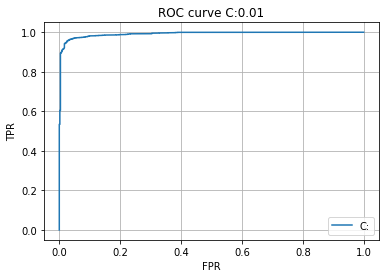

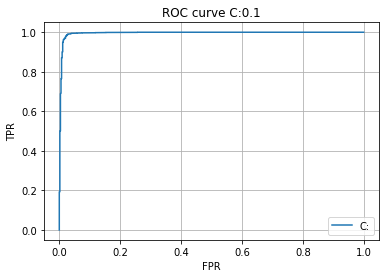

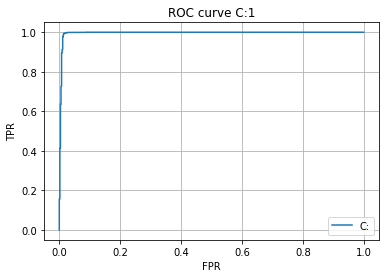

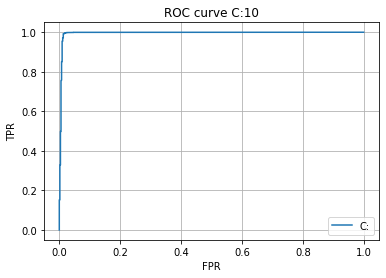

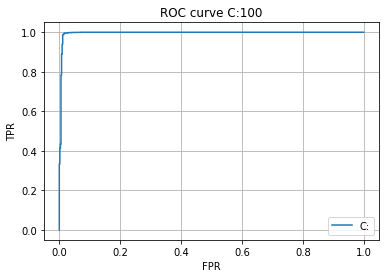

In [10]:
cs = [10**x for x in range(-2, 3)]
df_train_vec = df_train[dim_cols]
df_valid_vec = df_valid[dim_cols]
df_train_lab = df_train['label']
df_valid_lab = df_valid['label']

result_list = {}
for c in cs:
    ## Train and Predict with SVM ##
    svm = SVC(kernel='linear', C=c, probability=True)
    print('C:{} train start'.format(c))
    svm.fit(df_train_vec, df_train_lab)
    print('C:{} train end'.format(c))
    predicts = svm.predict(df_valid_vec)
    predict_probas = svm.predict_proba(df_valid_vec)[:, 1]
    ## Train and Predict with SVM ##
    print('Confusion matrix')
    ## Confusion Matrix
    cm = confusion_matrix(df_valid_lab, predicts)
    display(pd.DataFrame(cm, index=['actual_0', 'actual_1'], columns=['predict_0', 'predict_1']))
    '''
    accuracy: 正解率
    precision: 精度
    recall: 再現率
    '''
    accuracy = accuracy_score(df_valid_lab, predicts)
    precision = precision_score(df_valid_lab, predicts)
    recall = recall_score(df_valid_lab, predicts)
    f1 = f1_score(df_valid_lab, predicts)
    fpr_all, tpr_all, thresholds = roc_curve(df_valid_lab, predict_probas)
    auc_num = auc(fpr_all, tpr_all)
    print('Accuracy:{} Precision:{} Recall:{}, F1score:{}'.format(accuracy, precision, recall, f1))
    print('auc:{}'.format(auc_num))
    ## Describe ROC curve ##
    fig, axe = plt.subplots()
    axe.plot(fpr_all, tpr_all, label='C:'.format(c))
    axe.set_title('ROC curve C:{}'.format(c))
    axe.set_xlabel('FPR')
    axe.set_ylabel('TPR')
    axe.legend()
    axe.grid()
    result_list[c] = [accuracy, precision, recall, f1, svm]
    print()

### Test dataで確認する。

,predict_0,predict_1
actual_0,2107,38
actual_1,7,7599


Accuracy:0.9953850887088503 Precision:0.9950242241717953 Recall:0.999079673941625, F1score:0.9970478252312537
auc:0.9997873718883449


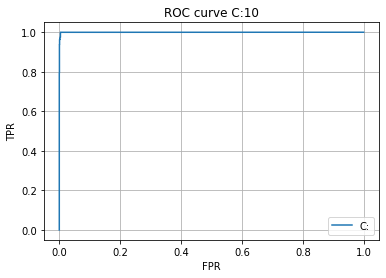

In [11]:
df_test_vec = df_train[dim_cols]
df_test_lab = df_train['label']

model = result_list[10][-1]
predicts = model.predict(df_test_vec)
predict_probas = svm.predict_proba(df_test_vec)[:, 1]
cm = confusion_matrix(df_test_lab, predicts)
display(pd.DataFrame(cm, index=['actual_0', 'actual_1'], columns=['predict_0', 'predict_1']))
accuracy = accuracy_score(df_test_lab, predicts)
precision = precision_score(df_test_lab, predicts)
recall = recall_score(df_test_lab, predicts)
f1 = f1_score(df_test_lab, predicts)
fpr_all, tpr_all, thresholds = roc_curve(df_test_lab, predict_probas)
auc_num = auc(fpr_all, tpr_all)
print('Accuracy:{} Precision:{} Recall:{}, F1score:{}'.format(accuracy, precision, recall, f1))
print('auc:{}'.format(auc_num))
## Describe ROC curve ##
fig, axe = plt.subplots()
axe.plot(fpr_all, tpr_all, label='C:'.format(10))
axe.set_title('ROC curve C:{}'.format(10))
axe.set_xlabel('FPR')
axe.set_ylabel('TPR')
axe.legend()
axe.grid()


# 交差検証


In [12]:
set_vec = df_set[dim_cols].values
set_lab = df_set['label'].values
kfold = StratifiedKFold(n_splits=10, random_state=8).split(set_vec, set_lab)
for i, (train, valid) in enumerate(kfold):
    svm = SVC(kernel='linear', C=10, probability=True)
    svm.fit(set_vec[train], set_lab[train])
    predicts = svm.predict(set_vec[valid])
    accuracy = accuracy_score(set_lab[valid], predicts)
    print('Fold:{} Accuracy:{}'.format(i, accuracy))

/Users/tomone_hata/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Fold:0 Accuracy:0.992616899097621
Fold:1 Accuracy:0.992616899097621
Fold:2 Accuracy:0.992616899097621
Fold:3 Accuracy:0.985233798195242
Fold:4 Accuracy:0.9934372436423298
Fold:5 Accuracy:0.9967186218211649
Fold:6 Accuracy:0.9901558654634947
Fold:7 Accuracy:0.9917965545529123
Fold:8 Accuracy:0.9786710418375718
Fold:9 Accuracy:0.9958949096880131
